In [ ]:
# Start writing code here...
import abc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from utils import *
import torch
import numpy as np
from fil_torch import FIL_Linear_torch, FIL_Logistic_torch
from numpy import linalg as LA
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures

### Experiement 1: FIL distribution of OOD data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-2.0, 2.0)

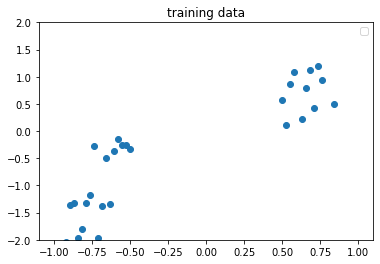

In [ ]:
# generate random data for OOD exploration
def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    
    return x_train, y_train, x_test

N = 20
noise_variance = 0.3
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
plt.scatter(x_train, y_train)#, label = "training data")
#plt.plot(x_test, y_test, 'orange', label = "MLE fitted polynomial regression")
plt.title("training data")
plt.legend()
plt.ylim(-2, 2)

#### Draw plot on OOD FIL distribution

In [ ]:
# Fit a model
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(1)
# Make an instance of the LinearRegression to perform regression
linear_model = LinearRegression(fit_intercept=False)
# Fit a polynomial model
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
linear_model.fit(x_train_poly, y_train)
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
y_test = linear_model.predict(x_test_poly)

# construct model for FIL
data = {"features": torch.from_numpy(x_train).reshape(-1, 1).float(), "targets": torch.from_numpy(y_train).float()}
model = FIL_Linear_torch()
model.train(data, lam = 1)

print('fisher info loss:', model.compute_all_fils())


fisher info loss: tensor([0.0366, 0.0349, 0.0208, 0.0180, 0.0141, 0.0137, 0.0174, 0.0158, 0.0127,
        0.0120, 0.0173, 0.0183, 0.0122, 0.0129, 0.0119, 0.0127, 0.0144, 0.0125,
        0.0118, 0.0102, 0.0084, 0.0135, 0.0088, 0.0098, 0.0217, 0.0149, 0.0108,
        0.0109, 0.0151, 0.0117, 0.0124, 0.0189, 0.0194, 0.0179, 0.0209, 0.0270,
        0.0185, 0.0218, 0.0286, 0.0251])
/work/fil_paper.py:67: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  theta = torch.solve(b[:, None], XTX)[0].squeeze(1)


Text(0.5, 1.0, 'Heatmap of FIL based on linear model of training data')

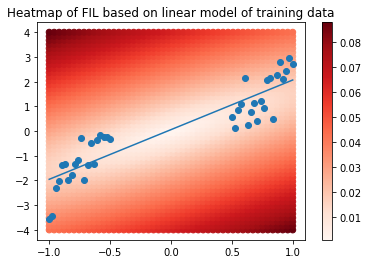

In [ ]:
x_range = np.linspace(-1, 1, 50)
y_range = np.linspace(-4, 4, 50)
fil_lst = []
y_final = []
x_final = []

#for x in x_range:
for y in y_range:
    fil_lst += model.fil(torch.from_numpy(x_range.reshape(-1, 1)).float(), torch.tensor(y).float())
    y_final += [y]*len(x_range)
    x_final += [x for x in x_range]
sc = plt.scatter(x_final, y_final, c = fil_lst, cmap = 'Reds')
plt.scatter(x_train, y_train)#, label = "training data")
plt.plot(x_test, y_test)
plt.colorbar(sc)
plt.title('Heatmap of FIL based on linear model of training data')

In [ ]:
model.compute_all_fils()

tensor([0.0366, 0.0349, 0.0208, 0.0180, 0.0141, 0.0137, 0.0174, 0.0158, 0.0127,
        0.0120, 0.0173, 0.0183, 0.0122, 0.0129, 0.0119, 0.0127, 0.0144, 0.0125,
        0.0118, 0.0102, 0.0084, 0.0135, 0.0088, 0.0098, 0.0217, 0.0149, 0.0108,
        0.0109, 0.0151, 0.0117, 0.0124, 0.0189, 0.0194, 0.0179, 0.0209, 0.0270,
        0.0185, 0.0218, 0.0286, 0.0251])

### Experiment 2: Overfitting Probe with FIL based on Polynomial Regression

Text(0.5, 1.0, 'Relationship between degree of polynomial and FIL')

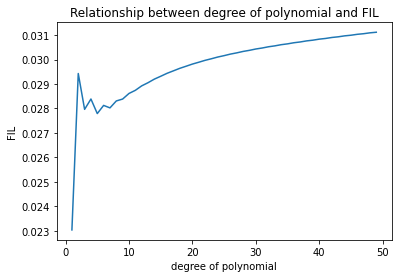

In [ ]:
# construct polynomial model
D = range(1, 50)
res = []
for d in D:
    d = int(d)
    poly = PolynomialFeatures(d)
    # Make an instance of the LinearRegression to perform regression
    linear_model = LinearRegression(fit_intercept=False)
    # Fit a polynomial model
    x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
    linear_model.fit(x_train_poly, y_train)
    #x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    #y_test = linear_model.predict(x_test_poly)

    data = {"features": torch.from_numpy(x_train_poly.reshape(-1, d+1)).float(), "targets": torch.from_numpy(y_train).float()}
    model = FIL_Linear_torch()
    model.train(data, lam = 1)
    fil = model.compute_all_fils()
    #print('fisher info loss:', fil) 
    #plt.scatter(x_train, y_train, c = fil, cmap = 'Greens')
    #res.append(LA.norm(np.array(fil)))
    res.append(np.mean(np.array(fil)))
    #res.append(model.jacobian_total())

plt.plot(D, res)
plt.xlabel('degree of polynomial')
plt.ylabel('FIL')
plt.title('Relationship between degree of polynomial and FIL')
# print("coefficients:{}".format(model.get_params()))

#J = model.jacobian_dataset(data)


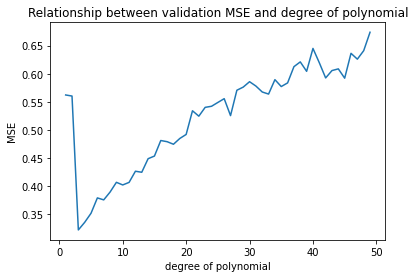

In [ ]:
# plot MSE on different degree of polynomial models
from sklearn.metrics import mean_squared_error

N = 20
noise_variance = 0.3
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
#D = [1, 3, 5, 10, 15, 20, 50, 100]
mse_list = []
S = 100
for d in D:
    mse_average_list = []
    for i in range(S):
        x_valid, y_valid, _ = generate_data(number_of_points=N, noise_variance=noise_variance)
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(d)

        # Make an instance of the LinearRegression to perform regression
        linear_model = LinearRegression(fit_intercept=False)
        # Fit a polynomial model
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        linear_model.fit(x_train_poly, y_train)
        x_valid_poly = poly.fit_transform(x_valid.reshape((-1, 1)))
        y_valid_pred = linear_model.predict(x_valid_poly)
        mse = mean_squared_error(y_valid, y_valid_pred)
        mse_average_list.append(mse)
    mse_list.append(np.mean(np.array(mse_average_list)))
    
plt.rcParams['figure.figsize'] = (6,4)
plt.plot(D, mse_list)
plt.title("Relationship between validation MSE and degree of polynomial")
plt.xlabel("degree of polynomial")
plt.ylabel("MSE")
plt.show()

### Experiment 3: FIL as indicator of OOD

#### construct toy data for classification and calculate epsitemic uncertainty

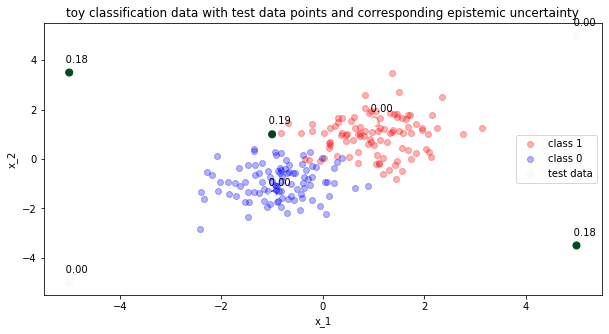

In [ ]:
# construct toy data for classification and calculate epsitemic uncertainty
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]
bayes = [0, 0.183, 0, 0.183, 0.187, 0, 0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
ax.scatter([x[0] for x in test_points], [x[1] for x in test_points], alpha=1., s=50, c=bayes, cmap = 'Greens', label='test data')
#    else:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color=fil[i])
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and corresponding epistemic uncertainty')
ax.legend(loc='best')
i = 0
for data in test_points:
    p1, p2 = data[0], data[1]
    fil_i = round(bayes[i], 2)
    label = "{:9.2f}".format(fil_i)

    plt.annotate(label, # this is the text
                 (p1,p2), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
        
    i += 1


plt.show()


#### calculate FIL on OOD data in classification toy dataset

fisher info loss: tensor([0.0063, 0.0037, 0.0042, 0.0030, 0.0033, 0.0029, 0.0053, 0.0067, 0.0075,
        0.0041, 0.0072, 0.0096, 0.0094, 0.0057, 0.0077, 0.0064, 0.0023, 0.0052,
        0.0027, 0.0097, 0.0064, 0.0078, 0.0077, 0.0044, 0.0054, 0.0056, 0.0030,
        0.0043, 0.0062, 0.0042, 0.0053, 0.0022, 0.0049, 0.0028, 0.0046, 0.0029,
        0.0039, 0.0032, 0.0058, 0.0048, 0.0049, 0.0063, 0.0032, 0.0057, 0.0035,
        0.0046, 0.0068, 0.0079, 0.0041, 0.0077, 0.0067, 0.0063, 0.0062, 0.0023,
        0.0068, 0.0064, 0.0062, 0.0034, 0.0036, 0.0037, 0.0086, 0.0084, 0.0088,
        0.0083, 0.0046, 0.0080, 0.0071, 0.0058, 0.0063, 0.0047, 0.0068, 0.0076,
        0.0090, 0.0084, 0.0061, 0.0044, 0.0053, 0.0047, 0.0032, 0.0028, 0.0053,
        0.0049, 0.0074, 0.0061, 0.0031, 0.0079, 0.0061, 0.0056, 0.0069, 0.0021,
        0.0050, 0.0029, 0.0041, 0.0028, 0.0065, 0.0023, 0.0043, 0.0035, 0.0055,
        0.0126, 0.0059, 0.0049, 0.0077, 0.0079, 0.0039, 0.0106, 0.0060, 0.0078,
        0.0107, 0.0077

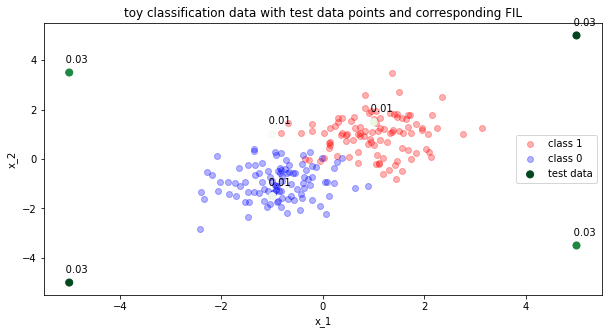

In [ ]:
# calculate FIL and plot
data = {"features": torch.from_numpy(x.reshape(-1, 2)).float(), "targets": torch.from_numpy(y).float()}
model = FIL_Logistic_torch()
model.train(data, l2 = 1)
print('fisher info loss:', model.compute_all_fils())

#x_test = []
#y_test = []
#for x_, y_ in test_points:
   # x_test.append([x_])
   # y_test.append(y_)
#x_test = np.array(x_test)
#y_test = np.array(y_test)
y_test = [0]*len(test_points)
fil = model.fil(torch.tensor(test_points).float(),torch.tensor(y_test).float()).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
ax.scatter([x[0] for x in test_points], [x[1] for x in test_points], alpha=1., s=50, c=fil, cmap = 'Greens', label='test data')
#    else:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color=fil[i])
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and corresponding FIL')
ax.legend(loc='best')
i = 0
for data in test_points:
    x, y = data[0], data[1]
    fil_i = round(fil[i], 2)
    label = "{:9.2f}".format(fil_i)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    i += 1
plt.show()


In [ ]:
fil

array([0.03430927, 0.02812634, 0.03470925, 0.02828245, 0.00694173,
       0.00880296, 0.00969529], dtype=float32)

### Experiment 5: OOD indicator of MNIST

#### train model on MNIST dataset

In [ ]:
# Construct 
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

features, targets = mnist_trainset.data, mnist_trainset.targets

features = features.float().div_(255.)
features = features.reshape(features.size(0), -1)


# only choose 0,1
# num_classes = 10
num_classes = 10

mask = targets.lt(num_classes)
x_train = features[mask, :]
y_train = targets[mask]

# x_train, mapping = pca(x_train, num_dims=20)

x_train.div_(x_train.norm(dim=1).max())
# y_train[y_train == 0] = -1
y_train = y_train.float()

x_train, mapping = pca(x_train, num_dims=20)

#num_samples = 100
#data = {"features": x_train, "targets": y_train}
data = {"features": torch.cat((x_train[(y_train == 0 )], x_train[(y_train == 1 )]), dim = 0), "targets": torch.cat((y_train[y_train == 0], y_train[y_train == 1]), dim = 0)}


model = FIL_Logistic_torch()
model.train(data, l2=8e-4)


/work/utils.py:93: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  _, projection = torch.symeig(covariance, eigenvectors=True)


In [ ]:
num_samples = 3
for i in range(1, -1, -1):
    x_test = x_train[y_train == i][:num_samples].detach()
    # x_test.div_(x_test.norm(dim=1).max())
    #x_test, _ = pca(x_test, mapping = mapping)
    y_test = y_train[y_train == i][:num_samples].detach()
    # y_test = torch.from_numpy(np.ones(num_samples))
    fil_set = model.fil(x_test, y_test)
    #print(fil_set)
    print(f'target = {i}, the mean of FIL is: ', fil_set.mean().item())
    #print(f'target = {i}, the norm of FIL matrix is ', model.jacobian_total().item()) #LA.norm(fil_set.detach().numpy()))

target = 1, the mean of FIL is:  0.03923014551401138
target = 0, the mean of FIL is:  0.04849151894450188


#### Calulate FIL on pictures of 2-9 digits as OOD

##### set label of OOD data as 1 and compute FIL

In [ ]:
num_samples = 200
for i in range(9, 1, -1):
    x_test = x_train[y_train == i][:num_samples].detach()
    # x_test.div_(x_test.norm(dim=1).max())
    #x_test, _ = pca(x_test, mapping = mapping)
    # y_test = y_train[y_train == i][:num_samples].detach()
    y_test = torch.from_numpy(np.ones(num_samples))
    fil_set = model.fil(x_test, y_test)
    
    #print(fil_set)
    print(f'target = {i}, the mean of FIL is: ', fil_set.mean().item())
    #print(f'target = {i}, the norm of FIL matrix is ', LA.norm(fil_set.detach().numpy()))

target = 9, the mean of FIL is:  0.10137035697698593
target = 8, the mean of FIL is:  0.09806421399116516
target = 7, the mean of FIL is:  0.10540179163217545
target = 6, the mean of FIL is:  0.10980885475873947
target = 5, the mean of FIL is:  0.11462453752756119
target = 4, the mean of FIL is:  0.11001786589622498
target = 3, the mean of FIL is:  0.11550014466047287
target = 2, the mean of FIL is:  0.11033065617084503


##### set label of OOD data as 0 and compute FIL

In [ ]:
#mask = targets.lt(10)
#features = features[mask, :]
#targets = targets[mask]
num_samples = 200
for i in range(9, 1, -1):
    x_test = x_train[y_train == i][:num_samples].detach()
    # x_test.div_(x_test.norm(dim=1).max())
    #x_test, _ = pca(x_test, mapping = mapping)
    # y_test = y_train[y_train == i][:num_samples].detach()
    y_test = torch.from_numpy(np.zeros(num_samples))
    fil_set = model.fil(x_test, y_test)
    #print(fil_set)
    print(f'target = {i}, the mean of FIL is: ', fil_set.mean().item())
    #print(f'target = {i}, the norm of FIL matrix is ', LA.norm(fil_set.detach().numpy()))

target = 9, the mean of FIL is:  0.11304988712072372
target = 8, the mean of FIL is:  0.11679263412952423
target = 7, the mean of FIL is:  0.11227171868085861
target = 6, the mean of FIL is:  0.10610923171043396
target = 5, the mean of FIL is:  0.10182512551546097
target = 4, the mean of FIL is:  0.11018401384353638
target = 3, the mean of FIL is:  0.11575022339820862
target = 2, the mean of FIL is:  0.11412297189235687


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3414c8e1-e8f2-444e-be94-05f51d01b06b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>